In [1]:
import pandas as pd
from siml_data import Featureset

In [2]:
feature_loader = Featureset()

In [3]:
df = feature_loader.get()

In [4]:
df.isna().sum().sum()

0

<Axes: >

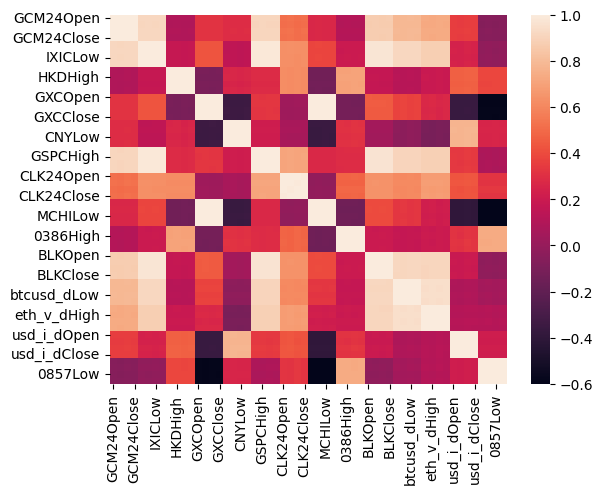

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(df.corr())

In [6]:
[x for x in df.columns if 'btc' in x.lower()]

['btcusd_dOpen', 'btcusd_dHigh', 'btcusd_dLow', 'btcusd_dClose']

In [7]:
df.corr()['btcusd_dClose'].abs().sort_values(ascending=False).drop([x for x in df.columns if 'Close' not in x]).head(10)

btcusd_dClose    1.000000
eth_v_dClose     0.945606
IXICClose        0.916503
BLKClose         0.912576
GSPCClose        0.902721
GCM24Close       0.786737
CLK24Close       0.605982
GXCClose         0.372193
MCHIClose        0.327378
0386Close        0.173504
Name: btcusd_dClose, dtype: float64

In [10]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
split = 0.75
split_idx = int(split * len(df))
X_train = df.iloc[:split_idx]
X_test = df.iloc[split_idx:]
Y_train = X_train

In [8]:
from siml_model import build_model

In [22]:
num_days = 10
model = build_model(num_days, df.shape[1])

In [23]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

In [ ]:
epochs = 6
batch = 256

history = model.fit(batched_data.X_train,
                    batched_data.Y_train,
                    validation_data=(batched_data.X_test,batched_data.Y_test),
                    epochs=epochs,
                    batch_size=batch)